# 03. Feature Analysis

Given a specific modeling approach, attempt to determine which features are attended for classification results. Additionally, attempt to obtain Shapley values for the features and present on a figure.


In [ ]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    print("Load Data")
data_df.head()

In [2]:
ad_df = data_df[(data_df["Study"] != "TBI") & (data_df["Harmonized"].notna())]
ad_evc = np.vstack(ad_df["EVC"])
ad_class = np.where(ad_df["Diagnosis"] == "AD", 1, 0)

In [3]:
state = 100

clf = svm.SVC(
    kernel="sigmoid", class_weight="balanced", probability=True, random_state=state
)

scaler = StandardScaler()
ad_evc_scaled = scaler.fit_transform(ad_evc)

x_train, x_test, y_train, y_test = train_test_split(
    ad_evc_scaled, ad_class, random_state=state, stratify=ad_class
)
feature_variance = pd.DataFrame(x_train).var(axis=0)
print("Feature Variance:\n", feature_variance)
clf.fit(x_train, y_train)
# best_model = clf

Feature Variance:
 0    1.157642
1    0.881075
2    1.037657
3    0.790010
4    1.167544
5    1.020746
dtype: float64


SVC(class_weight='balanced', kernel='sigmoid', probability=True,
    random_state=100)

In [4]:
svc_params = {
    "C": np.linspace(0.1, 10, 25),
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": np.logspace(1e-10, 1, 10),
}

gridsearch = GridSearchCV(
    estimator=clf,
    param_grid=svc_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=state),
    refit=True,
)
gridsearch.fit(x_train, y_train)
best_model = gridsearch.best_estimator_

In [5]:
explainer = shap.KernelExplainer(best_model.predict_proba, x_train)
shap_values = explainer.shap_values(x_test)
shap_pos_class = shap_values[:, :, 1]
shap_values_pos = shap.Explanation(
    values=shap_pos_class,
    base_values=explainer.expected_value[1],
    data=x_test,
    feature_names=[f"Feature {i+1}" for i in range(x_test.shape[1])],
)

Using 272 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 91/91 [00:19<00:00,  4.63it/s]


Best Model Parameters: {'C': np.float64(0.1), 'gamma': np.float64(1.0000000002302585), 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.60      0.70      0.65        46
           1       0.63      0.53      0.58        45

    accuracy                           0.62        91
   macro avg       0.62      0.61      0.61        91
weighted avg       0.62      0.62      0.61        91

Confusion Matrix:
 [[32 14]
 [21 24]]
Feature Importances:
 [0.03296703 0.03296703 0.0043956  0.04395604 0.03736264 0.02417582]


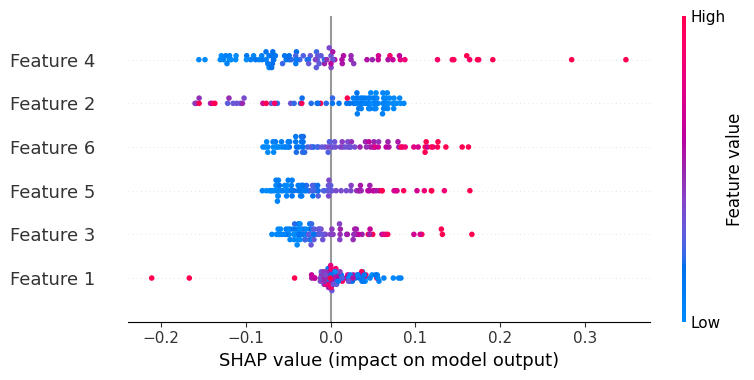

In [6]:
print("Best Model Parameters:", gridsearch.best_params_)

y_predict = best_model.predict(x_test)
print(classification_report(y_test, y_predict))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predict))

importances = permutation_importance(best_model, x_test, y_test, scoring="accuracy")
print("Feature Importances:\n", importances.importances_mean)

shap.summary_plot(
    shap_pos_class,
    x_test,
    feature_names=[f"Feature {i+1}" for i in range(x_test.shape[1])],
)

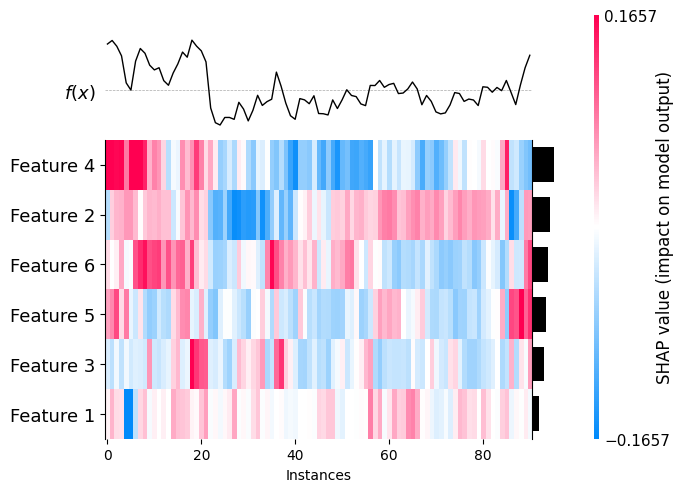

<Axes: xlabel='Instances'>

In [7]:
shap.plots.heatmap(shap_values_pos)

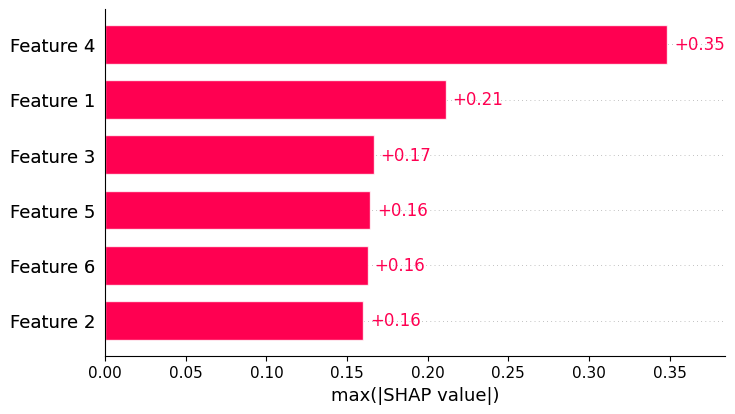

In [8]:
shap.plots.bar(shap_values_pos.abs.max(0))

In [ ]:
# Waterfall plots display individual predictions, so they expect a single row
# of an Explanation object as input
sample_ind = 0
shap.waterfall_plot(
    shap.Explanation(
        values=shap_pos_class[sample_ind],
        base_values=explainer.expected_value[1],
        data=x_test[sample_ind],
        feature_names=[f"Feature {i+1}" for i in range(x_test.shape[1])],
    )
)

NameError: name 'shap' is not defined

: 

### LASSO


In [10]:
from sklearn.linear_model import Lasso, lasso_path, LassoCV
from sklearn.metrics import mean_squared_error

reg = Lasso(alpha=1)
reg.fit(x_train, y_train)
print("R squared training set", round(reg.score(x_train, y_train) * 100, 2))
print("R squared test set", round(reg.score(x_test, y_test) * 100, 2))

# Training data
pred_train = reg.predict(x_train)
mse_train = mean_squared_error(y_train, pred_train)
print("MSE training set", round(mse_train, 2))

# Test data
pred = reg.predict(x_test)
mse_test = mean_squared_error(y_test, pred)
print("MSE test set", round(mse_test, 2))

R squared training set 0.0
R squared test set -0.0
MSE training set 0.25
MSE test set 0.25


Computing regularization path using the lasso...
Best alpha: 0.006210797953025557
R squared training set 11.49
R squared test set 5.42
MSE test: 0.23643233013100606


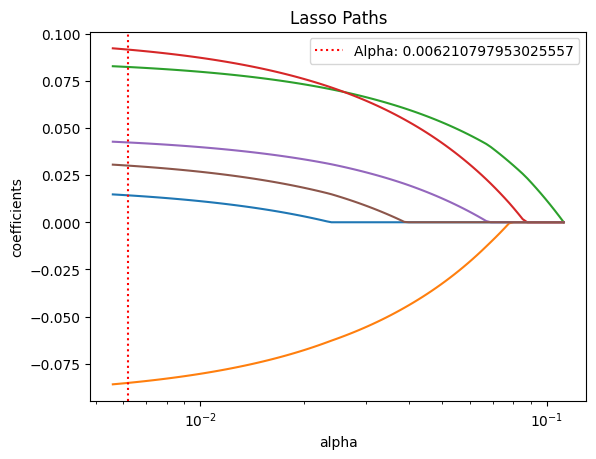

In [11]:
print("Computing regularization path using the lasso...")
eps = 5e-2
alphas_lasso, coefs_lasso, _ = lasso_path(x_train, y_train, eps=eps)

plt.figure(1)
for coef_lasso in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef_lasso)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
lasso_cv = LassoCV(cv=skf, random_state=state, max_iter=10000)
lasso_cv.fit(x_train, y_train)
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

plt.axvline(x=best_alpha, color="red", linestyle="dotted", label=f"Alpha: {best_alpha}")

lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(x_train, y_train)
coefficients = lasso_best.coef_
nonzero_indices = np.where(coefficients != 0)[0]

sorted_data = sorted(
    [
        (idx + 1, coef)
        for idx, coef in zip(nonzero_indices, coefficients[nonzero_indices])
    ],
    key=lambda x: abs(x[1]),
    reverse=True,
)
coefficients_df = pd.DataFrame(sorted_data, columns=["Feature Index", "Coefficient"])

print("R squared training set", round(lasso_best.score(x_train, y_train) * 100, 2))
print("R squared test set", round(lasso_best.score(x_test, y_test) * 100, 2))
print("MSE test:", mean_squared_error(y_test, lasso_best.predict(x_test)))

plt.legend()
plt.show()

(np.float64(7.16586485515816e-05),
 np.float64(0.14297780099657006),
 np.float64(0.21031609569208093),
 np.float64(0.25306108108026604))

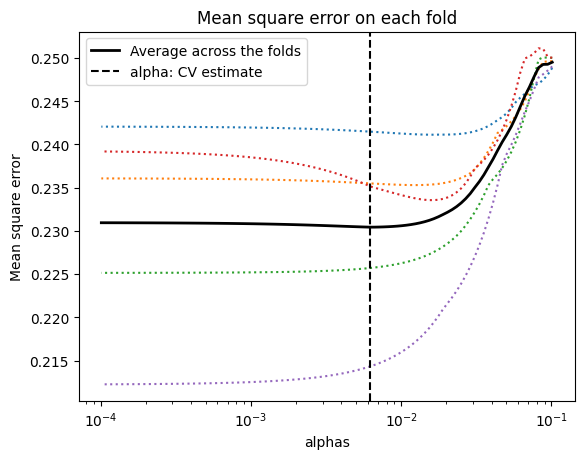

In [12]:
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, ":")
plt.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso_cv.alpha_, linestyle="--", color="k", label="alpha: CV estimate")

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# ymin, ymax = 50000, 250000
# plt.ylim(ymin, ymax);

In [13]:
coefficients_df

Feature Index  Coefficient
0              4     0.092548
1              3     0.076239
2              2    -0.074518
3              6     0.056245
4              5     0.028419
5              1    -0.010578

In [14]:
from sklearn.feature_selection import f_regression

f_stat, p_values = f_regression(ad_evc_scaled, ad_class)
feature_data = pd.DataFrame(
    {"Feature Index": range(1, len(p_values) + 1), "P-Value": p_values}
)

significant_features = feature_data[feature_data["P-Value"] < 0.05].sort_values(
    by="P-Value"
)
significant_features

Feature Index   P-Value
2              3  0.000421
3              4  0.000462
1              2  0.005661
5              6  0.015555
4              5  0.026808

In [15]:
# from pygam import LogisticGAM, s
# import scipy.sparse

# def to_array(self):
#     return self.toarray()

# scipy.sparse.spmatrix.A = property(to_array)

# np.int = np.int32
# np.float = np.float64
# np.bool = np.bool_
# x_t = pd.DataFrame(x_train)
# print(x_t)
# gam = LogisticGAM(verbose=True).fit(x_t, y_train)
# gam.summary()

In [16]:
# gam_opt = LogisticGAM().gridsearch(x_train, y_train)
# gam_opt.summary()

In [17]:
# pd.set_option('display.float_format', '{:.10f}'.format)
# feature_data.to_csv('out.csv')

### Apply to TBI Directly
Applies the grid-search model

In [18]:
from sklearn.metrics import accuracy_score

tbi_df = data_df[data_df["Study"] == "TBI"]
tbi_evc = np.vstack(tbi_df["EVC"])
tbi_class = np.where(tbi_df["Diagnosis"] == "POS", 1, 0)
tbi_scaled = scaler.fit_transform(tbi_evc)

y_pred = best_model.predict(tbi_evc)
accuracy = accuracy_score(tbi_class, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(tbi_class, y_pred))

Accuracy: 0.5818181818181818

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        28
           1       0.58      0.52      0.55        27

    accuracy                           0.58        55
   macro avg       0.58      0.58      0.58        55
weighted avg       0.58      0.58      0.58        55

